### Задание

Вы – продуктовый аналитик в классифайде недвижимости. Команда сделала дополнительную рассылку на объявления, которая вела на онбординг покупки платных услуг. Основная цель — увеличить выручку с объявлений.

Рассылка была произведена без рандомного деления на тест и контроль, поэтому мы не сможем использовать классический A/B-тест. Основная метрика теста — выручка (revenue) на объявление.

Вам предстоит проанализировать с помощью PSM выручку на объявления и выяснить, как она поменялась для тех, кто отреагировал на рассылку (treatment).

Будем работать с данными из таблицы `dataset_for_psm_hw.csv`

Описание данных:
- `price` - цена квартиры
- `year` - год постройки квартиры
- `floor` - этаж
- `rooms` - кол-во комнат в квартире
- `square` - площадь квартиры
- `revenue` - выручка
- `treatment` - отреагировал на рассылку
- `id` - id объявления

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", context="talk")
from sklearn.preprocessing import StandardScaler
from causalinference import CausalModel
from psmpy import PsmPy
from scipy import stats as st
import joblib
from scipy.stats import norm, ttest_ind
from tqdm import tqdm
from joblib import Parallel, delayed

pd.options.display.float_format = "{:.2f}".format

Задание 1. EDA (1/6)
 

Укажите абсолютную разницу между средними по параметру 'square' (разница для объявлений, которые воспользовались treatment и нет).

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [2]:
data = pd.read_csv("dataset_for_psm_hw.csv")
data.head()

,Unnamed: 0,price,year,floor,rooms,square,revenue,treatment,id
0,0,16500000.00,2009,17.00,1,39,0.00,0.00,0
1,1,23000000.00,2021,5.00,1,45,0.00,0.00,1
2,2,44700000.00,2015,4.00,2,79,0.00,1.00,2
3,3,10500000.00,2011,23.00,1,30,0.00,1.00,3
4,4,40000000.00,2022,5.00,2,71,0.00,0.00,4


In [3]:
group_a = data[data["treatment"] == 0]
group_b = data[data["treatment"] == 1]

In [4]:
mean_diff = group_b["square"].mean() - group_a["square"].mean()

round(mean_diff, 3)

8.082

### Задание 1. EDA (2/6)

Укажите стандартизированную разницу Cohen D effect size, где стандартное отклонение — это std по всему датафрейму по этой метрике.

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.



In [5]:
cohen_d = mean_diff / data["square"].std()

round(cohen_d, 3)

0.2

### Задание 1. EDA (3/6)

Какая доля объявлений воспользовалась treatment?

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [6]:
round(data[data["treatment"] == 1].shape[0] / data.shape[0], 3)

0.392

### Задание 1. EDA (4/6)

Найдите стандартизированный effect size Cohen D для метрики revenue (разница для объявлений, которые воспользовались treatment и нет).

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [7]:
mean_diff = group_b["revenue"].mean() - group_a["revenue"].mean()
cohen_d = mean_diff / data["revenue"].std()

round(cohen_d, 3)

0.065

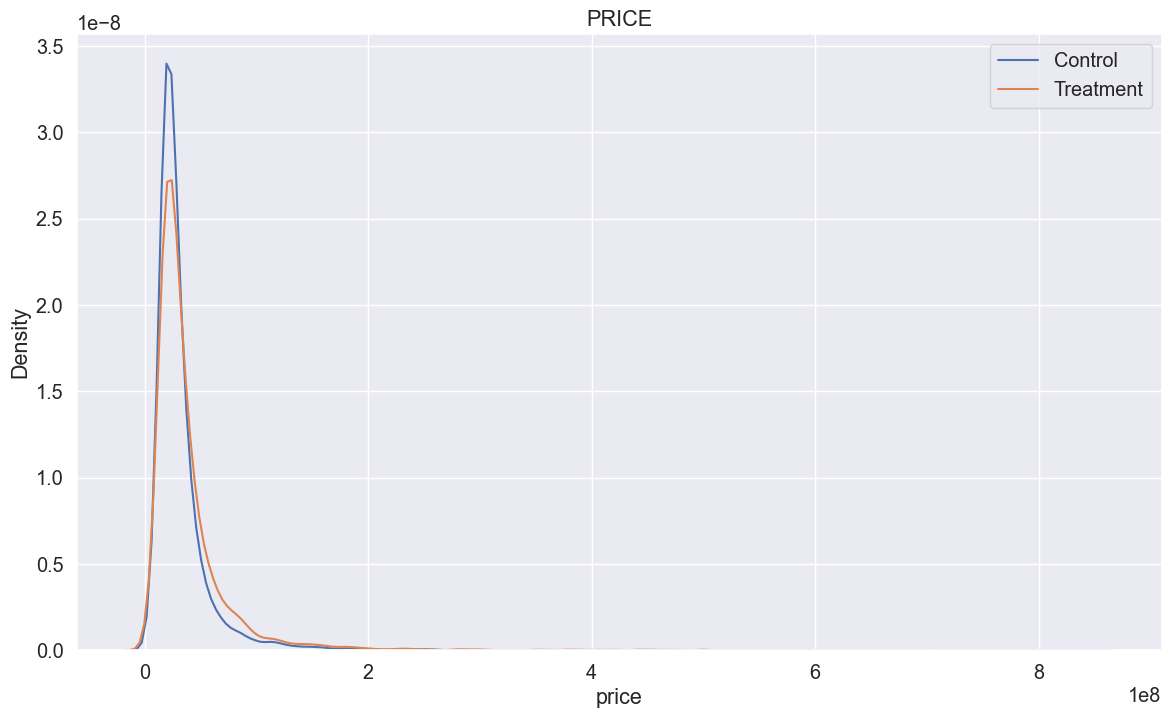

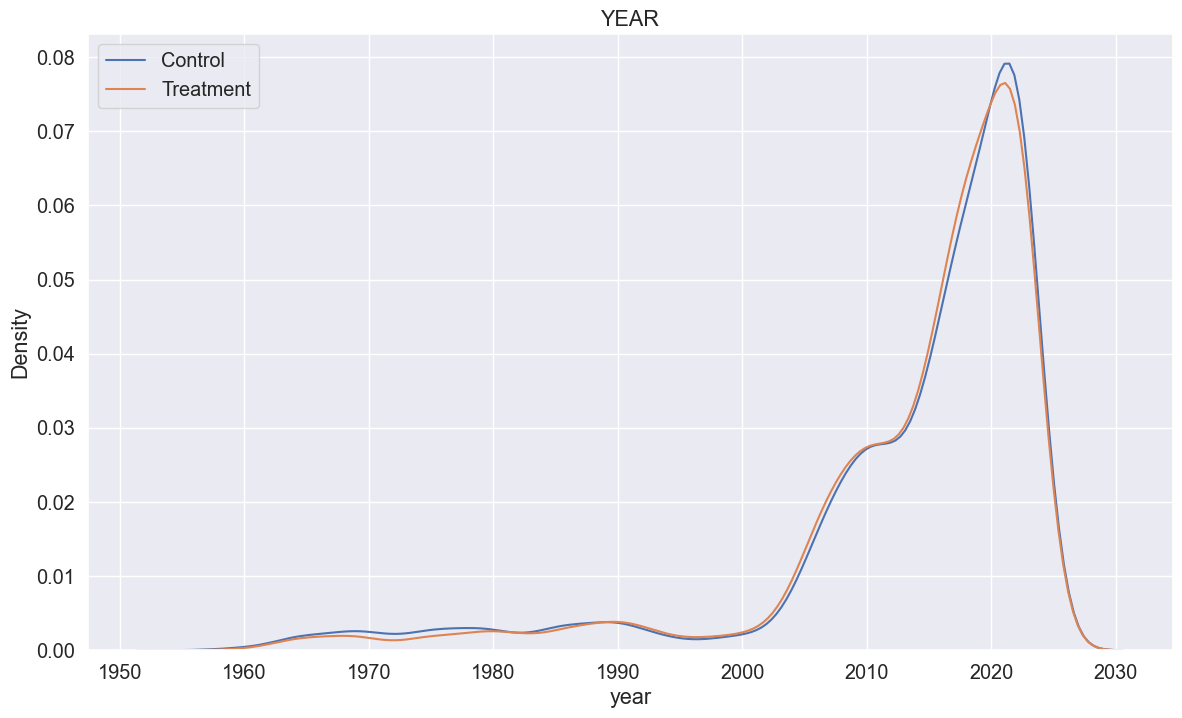

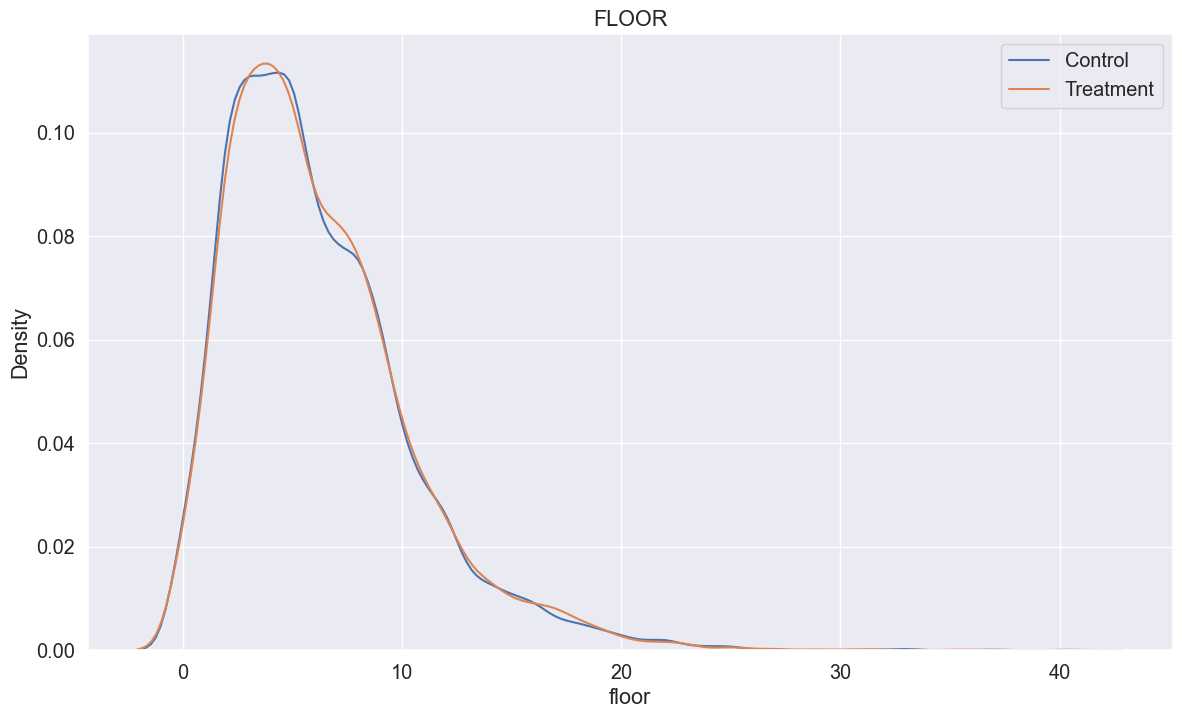

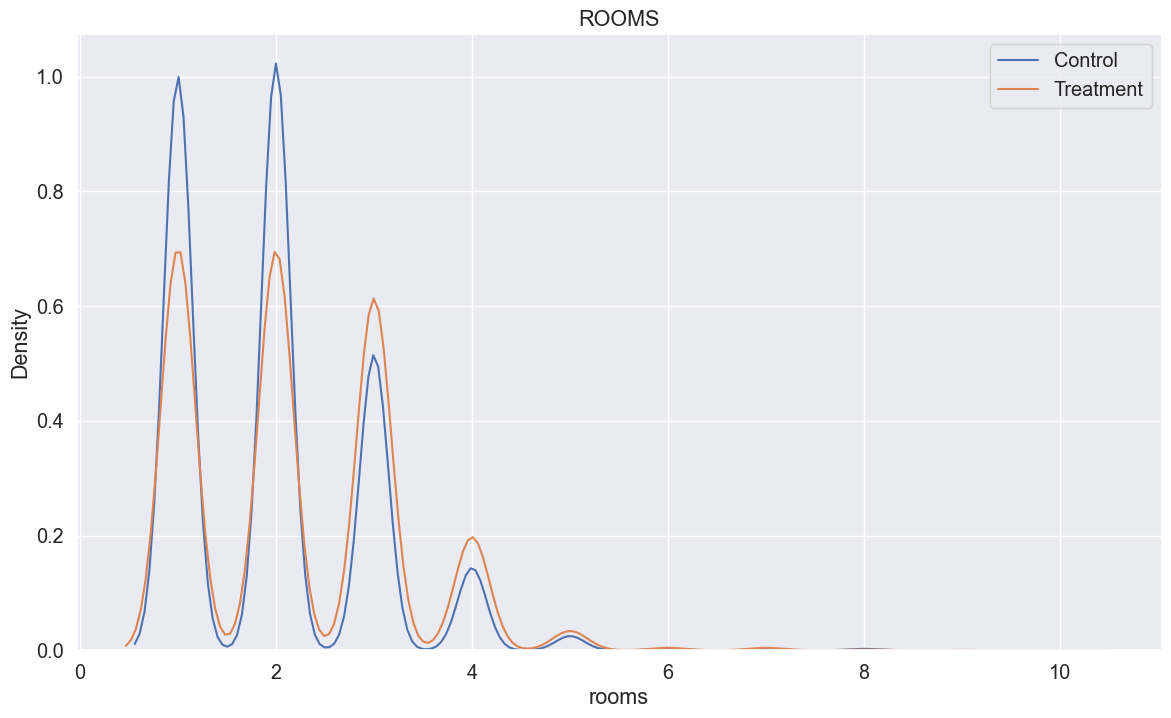

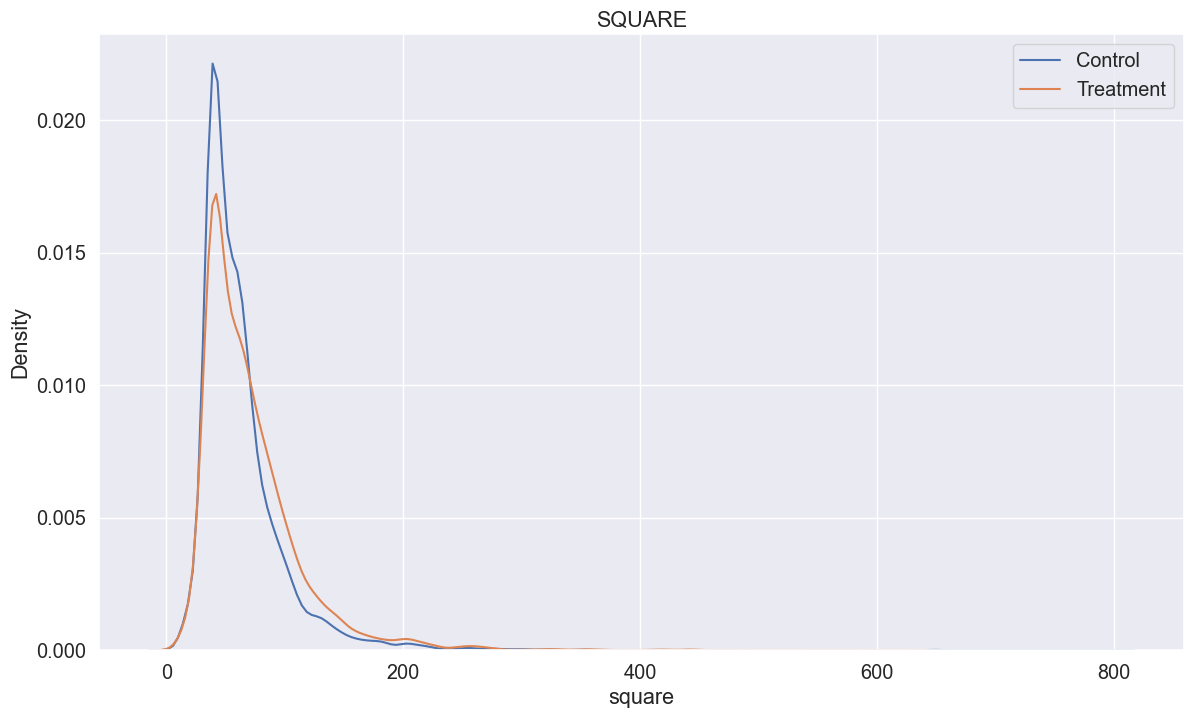

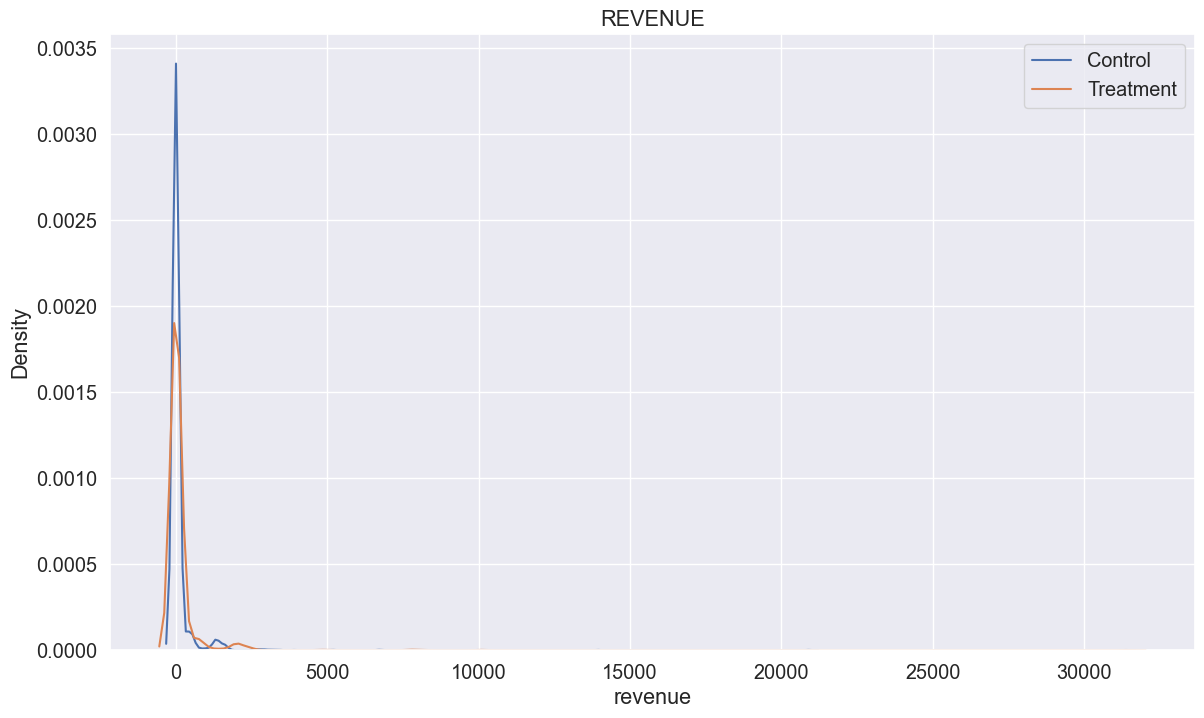

In [8]:
features = ["price", "year", "floor", "rooms", "square", "revenue"]

for feature in features:
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    sns.kdeplot(data=group_a, x=feature, label="Control")
    sns.kdeplot(data=group_b, x=feature, label="Treatment")
    plt.title(f"{feature.upper()}")
    plt.legend()

>**Ответ:** Группы различаются достаточно сильно сразу по нескольким параметрам

### Задание 1. EDA (6/6)

Можем ли мы напрямую сравнивать целевую метрику между treatment и control для нахождения эффекта?

>**Ответ:** Нет. По наблюдаемым параметрам есть различия в группах
>
>Действительно, мы не можем использовать для сравнения treatment и control таким, какой он есть. По наблюдаемым параметрам у нас есть расхождения, группы различаются, и в этом может быть искажение эффекта.


### Задание 2. PSM (1/8)

Какой "сырой" эффект (разницу между treatment и control) по данным видит модель?

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [9]:
%%time

y = data["revenue"].values
t = data["treatment"].values
X_ = data[["price", "year", "floor", "rooms", "square"]]

X_scaled = pd.DataFrame(
    StandardScaler().fit_transform(X_), columns=X_.columns
).values

model = CausalModel(y, t, X_scaled)
print(model.summary_stats)
model.est_propensity()

propensity_score = model.raw_data["pscore"]
propensity_score = np.where(
    propensity_score == 1, 0.9999999999, propensity_score
)

a = propensity_score
b = 1 - propensity_score
c = a / b
propensity_logit = pd.DataFrame(np.log(c)).replace(np.inf, 0).values

model = CausalModel(y, t, propensity_logit)
model.est_via_matching()
print(model.estimates)


Summary Statistics

                     Controls (N_c=12386)        Treated (N_t=7987)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y      105.143      700.598      162.644     1098.105       57.502

                     Controls (N_c=12386)        Treated (N_t=7987)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       -0.058        0.941        0.091        1.079        0.147
             X1       -0.011        1.030        0.016        0.952        0.027
             X2       -0.006        1.000        0.009        1.000        0.015
             X3       -0.090        0.954        0.140        1.053        0.229
             X4       -0.078        0.948        0.121        1.065        0.198


Trea

In [10]:
print(
    'Наблюдаемый, "сырой" эффект составил =',
    round(model.summary_stats["rdiff"], 3),
)

Наблюдаемый, "сырой" эффект составил = 57.502


### Задание 2. PSM (2/8)

Есть ли стат. значимый эффект при варианте замера ATE?

In [11]:
metric = "ate"
model_estimates = model.estimates.get("matching")
z = model_estimates.get(metric) / model_estimates.get(metric + "_se")
p_value_z = (1 - st.norm.cdf(abs(z))) * 2

if p_value_z < 0.05:
    print("Результаты стат. значимы")
else:
    print("Результаты не стат. значимы")


Результаты стат. значимы


### Задание 2. PSM (3/8)

Укажите p-value при оценке эффекта ATE.

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [12]:
metric = "ate"
model_estimates = model.estimates.get("matching")
z = model_estimates.get(metric) / model_estimates.get(metric + "_se")
p_value_z = (1 - st.norm.cdf(abs(z))) * 2

print("p-value =", round(p_value_z, 3))

p-value = 0.007


### Задание 2. PSM (4/8)

Какой размер эффекта ATE нашла PSM методика?

Введите значение в поле ниже с точностью до одного знака в десятичной части. Используйте точку для разделения целой и дробной части.

In [13]:
if p_value_z < 0.05:
    print("Результаты стат. значимы")
else:
    print("Результаты не стат. значимы")

print("p-value =", p_value_z)
print("Размер эффекта ATE =", round(model_estimates["ate"], 1))

Результаты стат. значимы
p-value = 0.006678995310919644
Размер эффекта ATE = 64.7


### Задание 2. PSM (5/8)

Есть ли стат. значимый эффект при варианте замера ATT?

In [14]:
metric = "att"
model_estimates = model.estimates.get("matching")
z = model_estimates.get(metric) / model_estimates.get(metric + "_se")
p_value_z = (1 - st.norm.cdf(abs(z))) * 2

if p_value_z < 0.05:
    print("Результаты стат. значимы")
else:
    print("Результаты не стат. значимы")

Результаты не стат. значимы


### Задание 2. PSM (6/8) 

Укажите p-value при оценке эффекта ATT. 

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [15]:
print("p-value =", round(p_value_z, 3))

p-value = 0.139


### Задание 2. PSM (7/8)

Какой размер эффекта ATT нашла PSM методика?

Введите значение в поле ниже с точностью до одного знака в десятичной части. Используйте точку для разделения целой и дробной части.

In [ ]:
print("Размер эффекта ATT =", round(model_estimates["att"], 1))

Размер эффекта ATT = 41.7


Задание 2. PSM (8/8)
 
Что означает наличие статистической значимости в ATC и ATE и отсутствие статистической значимости в ATT?

>**Ответ:** При "сведении" матчинга к `treatment == True` размер выборки меньше, чем при обратной стратегии матчинга и мера разброса целевой метрики revenue выше. Это снижает мощность теста именно при этом направлении матчинга.
>
>После того, как вы сматчили группы, работают те же принципы, что и для классических АБ-тестов. Чем больше выборка, тем выше мощность; чем вариативнее метрика, тем ниже мощность.